# Classifying Credit Card Fraud

In [119]:
# Standard Packages
import pandas as pd
import numpy as np
import markdown
import os
import haversine

    # Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt

    # Scipy Stats
import scipy.stats as stats
from scipy.special import logit, expit

    # Statsmodel Api
import statsmodels.api as sm
from statsmodels.formula.api import ols

    # SKLearn Modules
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, log_loss, confusion_matrix, RocCurveDisplay, classification_report, accuracy_score, recall_score, precision_score, f1_score, make_scorer, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn import datasets
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

    # Suppress future, deprecation, and SettingWithCopy warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

    # make all columns in a df viewable
pd.options.display.max_columns = None
pd.options.display.width = None

## The Business Problem

We've been hired by **Insert Credit Agency** to create a screener to help protect their clients from potentially fradulent purchases.

## Data Understanding

Data from Kaggle, Synthetically Generated, Already splitted for us. Synthetically Generated good because data like this usually encrypted/not available to public. No missing values, should be easier to clean and prep for analysis.

In [2]:
# Load in Fraud Test and Train
fraudTrain = pd.read_csv('data/fraudTrain.csv')
fraudTest = pd.read_csv('data/fraudTest.csv')
# Concatenate them for sake of EDA
fraudDF = pd.concat([fraudTrain, fraudTest], axis = 0)

In [3]:
fraudDF.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
fraudDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud           

We (obviously) have no missing values, since the data is artificially generated. However, their are some things that we need to set up in order to conduct our analysis.
1. Since we will be using unix time, as it is much easier to manipulate, we can drop trans_date_trans_time. 
2. Convert Gender Column into a boolean
3. Convert cc_num to a string
4. Find best identifier for transaction tracking (Name? Credit Card Number? Address? Some sort of mix?)
5. Drop useless columns, such as Unnamed:0 as that obviously does not effect whether or not a purchase is fraudulent

Via further analysis (Not included here), it seems that 1 of the people did not make any purchases with a credit card, so we only have 999 unique people in our dataset

## Data Preparation

In [5]:
fraudTrain.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [6]:
# Drop blatantly useless columns
fraudTrain.drop(['Unnamed: 0', 'merchant', 'dob', 'trans_num','job','merchant','cc_num','city','state'], axis = 1, inplace = True)
fraudTest.drop(['Unnamed: 0','merchant', 'dob', 'trans_num','job','merchant','cc_num','city','state'], axis = 1, inplace = True)
fraudDF.drop(['Unnamed: 0','merchant', 'dob', 'trans_num','job','merchant','cc_num','city','state'], axis = 1, inplace = True)

In [7]:
fraudDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 555718
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   category               object 
 2   amt                    float64
 3   first                  object 
 4   last                   object 
 5   gender                 object 
 6   street                 object 
 7   zip                    int64  
 8   lat                    float64
 9   long                   float64
 10  city_pop               int64  
 11  unix_time              int64  
 12  merch_lat              float64
 13  merch_long             float64
 14  is_fraud               int64  
dtypes: float64(5), int64(4), object(6)
memory usage: 226.1+ MB


In [8]:
fraudDF['full_name_street'] = fraudDF['first'] + ' ' + fraudDF['last'] + ' on ' + fraudDF['street']
fraudTest['full_name_street'] = fraudTest['first'] + ' ' + fraudTest['last'] + ' on ' + fraudTest['street']
fraudTrain['full_name_street'] = fraudTrain['first'] + ' ' + fraudTrain['last'] + ' on ' + fraudTrain['street']
fraudDF.drop(columns = ['first','last','street'], axis = 1, inplace = True)
fraudTrain.drop(columns = ['first','last','street'], axis = 1, inplace = True)
fraudTest.drop(columns = ['first','last','street'], axis = 1, inplace = True)

In [9]:
fraudTrain.set_index("full_name_street", inplace=True)
fraudTest.set_index("full_name_street", inplace=True)
fraudDF.set_index("full_name_street", inplace=True)
fraudTrain.reset_index(inplace=True)
fraudTest.reset_index(inplace=True)
fraudDF.reset_index(inplace = True)

In [10]:
fraudDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   full_name_street       object 
 1   trans_date_trans_time  object 
 2   category               object 
 3   amt                    float64
 4   gender                 object 
 5   zip                    int64  
 6   lat                    float64
 7   long                   float64
 8   city_pop               int64  
 9   unix_time              int64  
 10  merch_lat              float64
 11  merch_long             float64
 12  is_fraud               int64  
dtypes: float64(5), int64(4), object(4)
memory usage: 183.7+ MB


Convert trans_date_trans_time to Datetime Object

In [11]:
fraudDF['trans_date_trans_time'] = pd.to_datetime(fraudDF['trans_date_trans_time'])
fraudTrain['trans_date_trans_time'] = pd.to_datetime(fraudTrain['trans_date_trans_time'])
fraudTest['trans_date_trans_time'] = pd.to_datetime(fraudTest['trans_date_trans_time'])

Male or Female Mapping

In [12]:
fraudTrain['gender'][0]

'F'

In [13]:
if fraudTrain['gender'][0] == 'F': # Wrapper to not overtransform
    fraudTrain['gender'] = fraudTrain['gender'].map({'F': 0, 'M': 1})
    fraudTest['gender'] = fraudTest['gender'].map({'F': 0, 'M': 1})
    fraudDF['gender'] = fraudDF['gender'].map({'F': 0, 'M': 1})

One Hot Encoding Category of Purchase

In [14]:
if fraudTrain.columns[2] == 'category':
    categoryOHE = pd.get_dummies(fraudDF['category'], drop_first = True)
    fraudDF = pd.concat([fraudDF, categoryOHE], axis = 1)
    categoryOHETrain = pd.get_dummies(fraudTrain['category'], drop_first = True)
    fraudTrain = pd.concat([fraudTrain, categoryOHETrain], axis = 1)
    categoryOHETest = pd.get_dummies(fraudTest['category'], drop_first = True)
    fraudTest = pd.concat([fraudTest, categoryOHETest], axis = 1)
    fraudTrain.drop(columns = ['category'], axis = 1, inplace = True)
    fraudTest.drop(columns = ['category'], axis = 1, inplace = True)
    fraudDF.drop(columns = ['category'], axis = 1, inplace = True)

In [15]:
fraudTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 25 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   full_name_street       1296675 non-null  object        
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   amt                    1296675 non-null  float64       
 3   gender                 1296675 non-null  int64         
 4   zip                    1296675 non-null  int64         
 5   lat                    1296675 non-null  float64       
 6   long                   1296675 non-null  float64       
 7   city_pop               1296675 non-null  int64         
 8   unix_time              1296675 non-null  int64         
 9   merch_lat              1296675 non-null  float64       
 10  merch_long             1296675 non-null  float64       
 11  is_fraud               1296675 non-null  int64         
 12  food_dining            12966

In [16]:
fraudTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   full_name_street       555719 non-null  object        
 1   trans_date_trans_time  555719 non-null  datetime64[ns]
 2   amt                    555719 non-null  float64       
 3   gender                 555719 non-null  int64         
 4   zip                    555719 non-null  int64         
 5   lat                    555719 non-null  float64       
 6   long                   555719 non-null  float64       
 7   city_pop               555719 non-null  int64         
 8   unix_time              555719 non-null  int64         
 9   merch_lat              555719 non-null  float64       
 10  merch_long             555719 non-null  float64       
 11  is_fraud               555719 non-null  int64         
 12  food_dining            555719 non-null  uint

New Features: Distance from Home, Distance from Last Purchase, Time of Purchase, Time Since Last Purchase

Merchant's Distance From Home

In [17]:
# Haversine Function for Calculating Distance Between Place of Purchase, Home of Customer
def distance(lat1, lon1, lat2, lon2):
    coords1 = (lat1, lon1)
    coords2 = (lat2, lon2)
    return haversine.haversine(coords1, coords2)

In [18]:
fraudDF['distance_from_home'] = fraudDF.apply(lambda row: distance(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)
fraudTrain['distance_from_home'] = fraudTrain.apply(lambda row: distance(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)
fraudTest['distance_from_home'] = fraudTest.apply(lambda row: distance(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)

Text(0.5, 1.0, 'Histogram of Fraudulent Purchases by Distance')

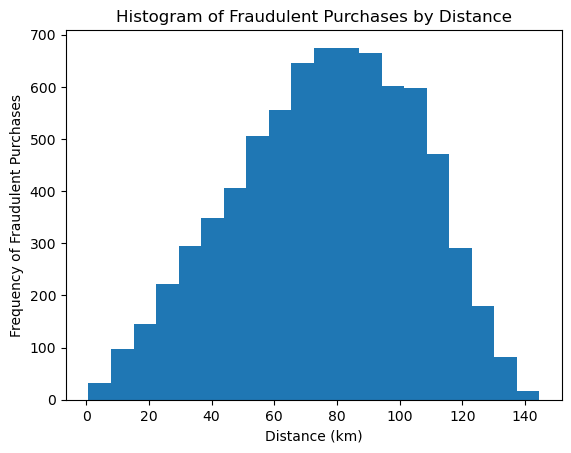

In [152]:
plt.hist(fraudTrain[fraudTrain["is_fraud"] == 1]["distance_from_home"], bins=20)
plt.xlabel("Distance (km)")

# set the y-axis label
plt.ylabel("Frequency of Fraudulent Purchases")

# set the title of the graph
plt.title("Histogram of Fraudulent Purchases by Distance")


In [19]:
fraudTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   full_name_street       1296675 non-null  object        
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   amt                    1296675 non-null  float64       
 3   gender                 1296675 non-null  int64         
 4   zip                    1296675 non-null  int64         
 5   lat                    1296675 non-null  float64       
 6   long                   1296675 non-null  float64       
 7   city_pop               1296675 non-null  int64         
 8   unix_time              1296675 non-null  int64         
 9   merch_lat              1296675 non-null  float64       
 10  merch_long             1296675 non-null  float64       
 11  is_fraud               1296675 non-null  int64         
 12  food_dining            12966

Time of Purchase

In [20]:
# converting Time column to datetime
fraudTrain["Time"] = pd.to_datetime(fraudTrain["trans_date_trans_time"]).dt.hour
fraudTest["Time"] = pd.to_datetime(fraudTest["trans_date_trans_time"]).dt.hour

In [21]:
# Categorize by Time of Day
fraudTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 27 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   full_name_street       1296675 non-null  object        
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   amt                    1296675 non-null  float64       
 3   gender                 1296675 non-null  int64         
 4   zip                    1296675 non-null  int64         
 5   lat                    1296675 non-null  float64       
 6   long                   1296675 non-null  float64       
 7   city_pop               1296675 non-null  int64         
 8   unix_time              1296675 non-null  int64         
 9   merch_lat              1296675 non-null  float64       
 10  merch_long             1296675 non-null  float64       
 11  is_fraud               1296675 non-null  int64         
 12  food_dining            12966

In [22]:
fraudTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 27 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   full_name_street       1296675 non-null  object        
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   amt                    1296675 non-null  float64       
 3   gender                 1296675 non-null  int64         
 4   zip                    1296675 non-null  int64         
 5   lat                    1296675 non-null  float64       
 6   long                   1296675 non-null  float64       
 7   city_pop               1296675 non-null  int64         
 8   unix_time              1296675 non-null  int64         
 9   merch_lat              1296675 non-null  float64       
 10  merch_long             1296675 non-null  float64       
 11  is_fraud               1296675 non-null  int64         
 12  food_dining            12966

Time Since Last Purchase

In [23]:
fraudTrain['TimeSinceLast'] = fraudTrain.groupby(by = 'full_name_street')['unix_time'].diff()
fraudTest['TimeSinceLast'] = fraudTest.groupby(by = 'full_name_street')['unix_time'].diff()

In [24]:
fraudTrain['TimeSinceLast'] = fraudTrain['TimeSinceLast'].fillna(-1)
fraudTest['TimeSinceLast'] = fraudTest['TimeSinceLast'].fillna(-1)

if fraudTrain.columns[27] == 'TimeSinceLast':
    fraudTrain.drop(columns= ['Time'], axis = 1, inplace = True)
    fraudTest.drop(columns= ['Time'], axis = 1, inplace = True)

In [25]:
fraudTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   full_name_street       555719 non-null  object        
 1   trans_date_trans_time  555719 non-null  datetime64[ns]
 2   amt                    555719 non-null  float64       
 3   gender                 555719 non-null  int64         
 4   zip                    555719 non-null  int64         
 5   lat                    555719 non-null  float64       
 6   long                   555719 non-null  float64       
 7   city_pop               555719 non-null  int64         
 8   unix_time              555719 non-null  int64         
 9   merch_lat              555719 non-null  float64       
 10  merch_long             555719 non-null  float64       
 11  is_fraud               555719 non-null  int64         
 12  food_dining            555719 non-null  uint

In [26]:
fraudTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 27 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   full_name_street       1296675 non-null  object        
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   amt                    1296675 non-null  float64       
 3   gender                 1296675 non-null  int64         
 4   zip                    1296675 non-null  int64         
 5   lat                    1296675 non-null  float64       
 6   long                   1296675 non-null  float64       
 7   city_pop               1296675 non-null  int64         
 8   unix_time              1296675 non-null  int64         
 9   merch_lat              1296675 non-null  float64       
 10  merch_long             1296675 non-null  float64       
 11  is_fraud               1296675 non-null  int64         
 12  food_dining            12966

In [27]:
fraudTrain.drop(['lat','long','unix_time','merch_lat','merch_long'], axis = 1, inplace = True)
fraudTest.drop(['lat','long','unix_time','merch_lat','merch_long'], axis = 1, inplace = True)

In [135]:
fraudTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   full_name_street       1296675 non-null  object        
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   amt                    1296675 non-null  float64       
 3   gender                 1296675 non-null  int64         
 4   zip                    1296675 non-null  int64         
 5   city_pop               1296675 non-null  int64         
 6   is_fraud               1296675 non-null  int64         
 7   food_dining            1296675 non-null  uint8         
 8   gas_transport          1296675 non-null  uint8         
 9   grocery_net            1296675 non-null  uint8         
 10  grocery_pos            1296675 non-null  uint8         
 11  health_fitness         1296675 non-null  uint8         
 12  home                   12966

## Modeling

##### Business Problem specifies that we a creating a screener, so we want to catch almost all fraudulent purchases, don't care too much about False-Positives, so we will use Recall as our scoring metric.

Obviously, if we classify every purchase as fradulent, we would get a recall of 1, but that would be an extremely shitty screener. We have to do more work than that. Let's make a baseline logistic regression model, just with the columns we currently have- not taking anything else into account. We would expect this to be a bad model, but it is a good place to start.

In [28]:
X_train = fraudTrain.drop(['is_fraud','trans_date_trans_time', 'full_name_street', 'zip'], axis = 1)
y_train = fraudTrain['is_fraud']
X_test = fraudTest.drop(['is_fraud','trans_date_trans_time','full_name_street','zip'], axis = 1)
y_test = fraudTest['is_fraud']
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 19 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   amt                 1296675 non-null  float64
 1   gender              1296675 non-null  int64  
 2   zip                 1296675 non-null  int64  
 3   city_pop            1296675 non-null  int64  
 4   food_dining         1296675 non-null  uint8  
 5   gas_transport       1296675 non-null  uint8  
 6   grocery_net         1296675 non-null  uint8  
 7   grocery_pos         1296675 non-null  uint8  
 8   health_fitness      1296675 non-null  uint8  
 9   home                1296675 non-null  uint8  
 10  kids_pets           1296675 non-null  uint8  
 11  misc_net            1296675 non-null  uint8  
 12  misc_pos            1296675 non-null  uint8  
 13  personal_care       1296675 non-null  uint8  
 14  shopping_net        1296675 non-null  uint8  
 15  shopping_pos   

In [29]:
from imblearn.over_sampling import SMOTE
SMT = SMOTE(random_state = 42)
SS = StandardScaler()
BaselineModel = LogisticRegression(random_state = 42, solver = 'saga')
pipelineLog = Pipeline([('Scaler', SS),('SMOTE', SMT),('LogModel', BaselineModel)])

In [30]:
pipelineLog.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()), ('SMOTE', SMOTE(random_state=42)),
                ('LogModel',
                 LogisticRegression(random_state=42, solver='saga'))])

In [31]:
y_pred_test = pipelineLog.predict(X_test)
y_pred_train = pipelineLog.predict(X_train)
print(recall_score(y_train, y_pred_train))
print(recall_score(y_test, y_pred_test))
confusion_matrix(y_test, y_pred_test)

0.7498001598721024
0.7375291375291375


array([[488840,  64734],
       [   563,   1582]], dtype=int64)

Hyperparameter Tuning for Model

In [169]:
# Custom Scorers
def custom_recall_score(y_true, y_pred_prob, threshold):
    y_pred = (y_pred_prob >= threshold).astype(int)
    return recall_score(y_true, y_pred)

def false_positive_rate(y_true, y_pred_prob, threshold):
    y_pred = y_pred_prob >= threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (tn + fp)

In [33]:
for n in range(1,6):
    scorer = make_scorer(custom_recall_score, threshold = n/10, needs_proba=True)
    param_gridLog = {'LogModel__C': [i/2 for i in range(10, 51, 5)], 'LogModel__penalty': ['l2','l1']} #  scoring__threshold': [i/20 for i in range(1, 10)] 
    grid_search = RandomizedSearchCV(pipelineLog, param_distributions = param_gridLog, scoring=scorer, cv=5)
    print(f'Fitting iteration {n}')
    grid_search.fit(X_train, y_train)
    print(f'Scoring Threshold: {n/20}')
    print("Best threshold value:", grid_search.best_params_)
    print("Best recall score:", grid_search.best_score_)

In [35]:
bestModel = LogisticRegression(random_state = 42, solver = 'saga', C = 22.5)
scorer = make_scorer(custom_recall_score, threshold = 0.1, needs_proba= True)
pipelineLogBest = Pipeline([('Scaler', SS),('SMOTE', SMT),('LogModel', bestModel)])
pipelineLogBest.fit(X_train, y_train)

0.7375291375291375
0.7498001598721024


array([[488839,  64735],
       [   563,   1582]], dtype=int64)

Test Score Recall: 0.8680652680652681
Train Score Recall: 0.8754329869437784
Test Score FP Rate: 0.3177822657856041
Train Score FP Rate: 0.3076315052564869


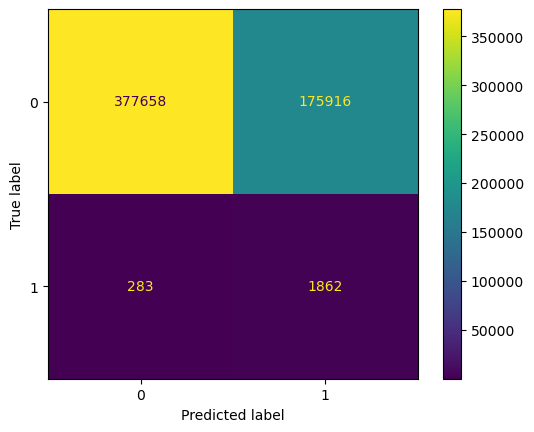

In [176]:
y_pred_testProb = pipelineLogBest.predict_proba(X_test)
y_pred_trainProb = pipelineLogBest.predict_proba(X_train)
print(f"Test Score Recall: {custom_recall_score(y_test, y_pred_testProb[:,1], 0.3)}")
print(f"Train Score Recall: {custom_recall_score(y_train, y_pred_trainProb[:,1], 0.3)}")
print(f"Test Score FP Rate: {false_positive_rate(y_test, y_pred_testProb[:,1], 0.3)}")
print(f"Train Score FP Rate: {false_positive_rate(y_train, y_pred_trainProb[:,1], 0.3)}")
y_pred_test = (y_pred_testProb[:,1] >= 0.3).astype(int)
y_pred_train = (y_pred_trainProb[:,1] >= 0.3).astype(int)

# calculate the confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test)
cm_train = confusion_matrix(y_train, y_pred_train)

display = ConfusionMatrixDisplay(confusion_matrix = cm_test)
display.plot()

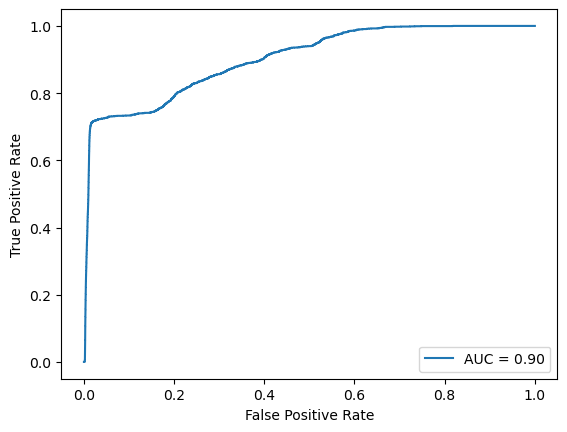

In [180]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred_testProb[:,1])
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc)
display.plot()

Decision Tree

In [84]:
dt_clf = DecisionTreeClassifier(random_state= 42)
pipelineDT = Pipeline([('Scaler', SS),('SMOTE', SMT),('TreeModel', dt_clf)])
pipelineDT.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()), ('SMOTE', SMOTE(random_state=42)),
                ('TreeModel', DecisionTreeClassifier(random_state=42))])

In [103]:
y_pred_test = pipelineDT.predict(X_test)
y_pred_train = pipelineDT.predict(X_train)
print(recall_score(y_train, y_pred_train))
print(recall_score(y_test, y_pred_test))
confusion_matrix(y_test, y_pred_test)
n_node_samples = dt_clf.tree_.n_node_samples

leaf_indices = np.where(dt_clf.tree_.children_left == -1)[0]

# calculate the average number of samples in each leaf node
avg_samples_per_leaf = np.mean(n_node_samples[leaf_indices])

# print the average number of samples in each leaf node
print("Average number of samples per leaf:", avg_samples_per_leaf)

1.0
0.7664335664335664
Average number of samples per leaf: 139.75489186405767


So we're overfitting. Shocker. Let's do some grid search to find the best parameters to maximize recall score

In [107]:
param_gridDT = {'TreeModel__max_depth': [20,25,30,35,40], 'TreeModel__min_samples_split': [200,400,600,800,1000]}
grid_search = RandomizedSearchCV(pipelineDT, param_distributions = param_gridDT, scoring = 'recall', cv=5)
grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                             ('SMOTE', SMOTE(random_state=42)),
                                             ('TreeModel',
                                              DecisionTreeClassifier(random_state=42))]),
                   param_distributions={'TreeModel__max_depth': [20, 25, 30, 35,
                                                                 40],
                                        'TreeModel__min_samples_split': [200,
                                                                         400,
                                                                         600,
                                                                         800,
                                                                         1000]},
                   scoring='recall')

In [108]:
print("Best threshold value:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

Best threshold value: {'TreeModel__min_samples_split': 600, 'TreeModel__max_depth': 20}
Best recall score: 0.9205963889142703


In [124]:
dt_clfBest = DecisionTreeClassifier(random_state= 42, min_samples_split = 600, max_depth= 20)
pipelineDTBest = Pipeline([('Scaler', SS),('SMOTE', SMT),('TreeModel', dt_clfBest)])
pipelineDTBest.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()), ('SMOTE', SMOTE(random_state=42)),
                ('TreeModel',
                 DecisionTreeClassifier(max_depth=20, min_samples_split=600,
                                        random_state=42))])

Recall: 0.8680652680652681
FP Rate: 0.3177822657856041


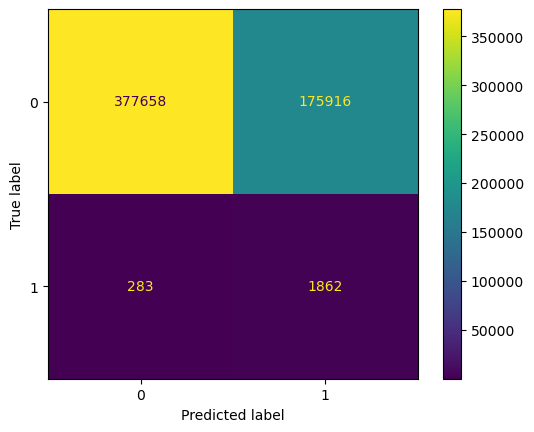

In [182]:
y_pred_testDT = pipelineDTBest.predict(X_test)
y_pred_train = pipelineDTBest.predict(X_train)
print('Recall:', recall_score(y_test, y_pred_test))
print('FP Rate:', false_positive_rate(y_test, y_pred_test, 0.5))
cm_dt = confusion_matrix(y_test, y_pred_test)
display = ConfusionMatrixDisplay(confusion_matrix = cm_dt)
display.plot()

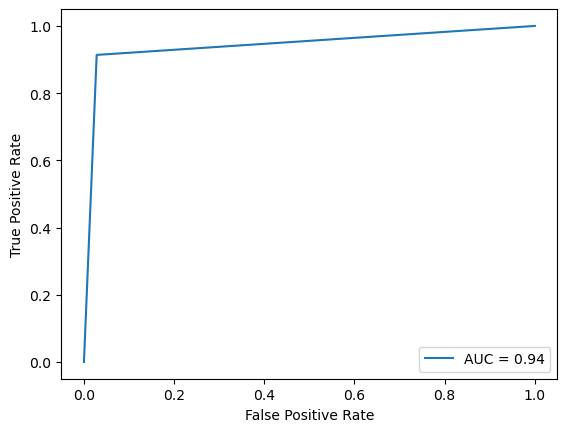

In [186]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_testDT)
roc_aucDT = auc(fpr, tpr)
display = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_aucDT)
display.plot()

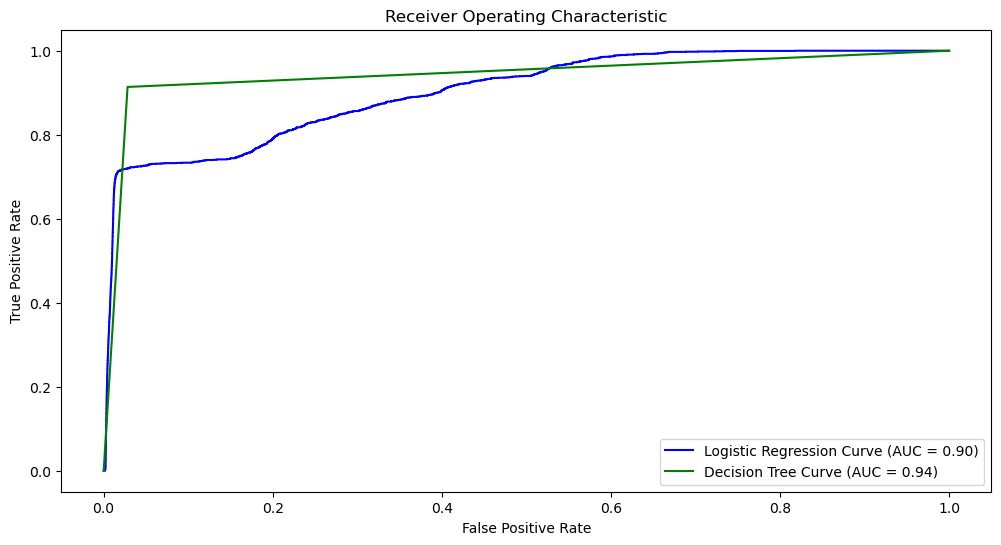

In [189]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_testProb[:,1])
roc_auc1 = auc(fpr1, tpr1)

# Data for the Decision Tree ROC curve
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_testDT)
roc_auc2 = auc(fpr2, tpr2)

# Plot the ROC curves
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(fpr1, tpr1, color='blue', label='Logistic Regression (AUC = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', label='Decision Tree (AUC = %0.2f)' % roc_auc2)

# Add labels and legend
plt.title('ROC Curves of Logistic Regression, Decision Tree Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [194]:
# Feature Importance
features_used = X_train.columns
feature_ranking = []
for fi, feature in zip(dt_clfBest.feature_importances_, features_used):
    feature_ranking.append((fi, feature))
feature_ranking.sort(reverse = True)
feature_ranking

[(0.7515573560796109, 'amt'),
 (0.0833764598539585, 'gas_transport'),
 (0.02067220862124585, 'travel'),
 (0.017341346378179086, 'home'),
 (0.017168558060540053, 'grocery_net'),
 (0.01677485318198328, 'misc_pos'),
 (0.016200603393112925, 'food_dining'),
 (0.014275859666428864, 'TimeSinceLast'),
 (0.012213905914564054, 'city_pop'),
 (0.008001122708576761, 'shopping_net'),
 (0.007597198272058207, 'zip'),
 (0.007516894282898414, 'gender'),
 (0.00590336732341959, 'distance_from_home'),
 (0.0051499783323841536, 'kids_pets'),
 (0.004943952555393311, 'shopping_pos'),
 (0.004485452952285335, 'personal_care'),
 (0.003125215572199076, 'grocery_pos'),
 (0.002303913791014964, 'misc_net'),
 (0.0013917530601465237, 'health_fitness')]

## Evaluation

## Code Quality???

Text(0.5, 1.0, 'Fraudulent Purchases based on Time Since Last Transaction')

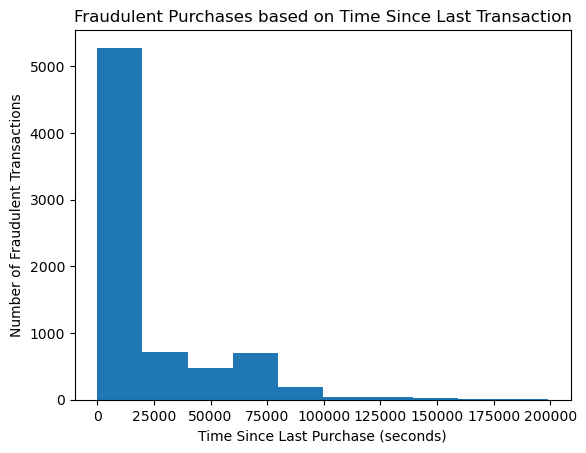

In [179]:
plt.hist(fraudTrain[fraudTrain['is_fraud'] == 1]['TimeSinceLast'][fraudTrain['TimeSinceLast'] <= 200000])
# set the x-axis label
plt.xlabel('Time Since Last Purchase (seconds)')

# set the y-axis label
plt.ylabel('Number of Fraudulent Transactions')

plt.title('Fraudulent Purchases based on Time Since Last Transaction')